In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import sys

import tgt
import os
import numpy as np
from tqdm import tqdm
import torchaudio
import librosa
import glob

sys.path.append("/mntcephfs/lab_data/shoinoue/Models/trained_models/vocos/vocos16k_noncausal_tealab/")
from vocos16k_inference import Vocos

sys.path.append("../../cuhksz-phd/sho_util/pyfiles/")
from pytorch import cuda2numpy, cuda2cpu
from basic import plot_spectrogram
from sound import play_audio

from vocos.feature_extractors import MelSpectrogramFeatures, EncodecFeatures

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
def get_pretrained_model(config_path, model_path):
    if fs==24000:
        model = Vocos.from_hparams(config_path)
        state_dict = torch.load(model_path, map_location="cpu")
        if isinstance(model.feature_extractor, EncodecFeatures):
            encodec_parameters = {
                "feature_extractor.encodec." + key: value
                for key, value in model.feature_extractor.encodec.state_dict().items()
            }
            state_dict.update(encodec_parameters)
        model.load_state_dict(state_dict)
        model.eval();
    elif fs==16000:
        model = Vocos.from_hparams(config_path)
        state_dict_list = torch.load(model_path, map_location="cpu")
        state_dict = state_dict_list['state_dict']
        model_state_dict = model.state_dict()
        new_state_dict = {}
        for key, v in state_dict.items():
            if key in model_state_dict.keys():
                # print(key)
                new_state_dict[key] = v

        if isinstance(model.feature_extractor, EncodecFeatures):
            encodec_parameters = {
                "feature_extractor.encodec." + key: value
                for key, value in model.feature_extractor.encodec.state_dict().items()
            }
            state_dict.update(encodec_parameters)
        model.load_state_dict(new_state_dict, strict=True)
        model.eval();
    return model

In [3]:
data_dir = "/mntcephfs/lab_data/shoinoue/"
fs = 24000
# fs = 16000

if fs==24000:
    config_path = f"{data_dir}Models/trained_models/vocos/24k/config.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/24k/pytorch_model.bin"
elif fs==16000:
    config_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/config16k.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/vocos16k_noncausal_last.ckpt"
    
dataset_dir = data_dir + "Dataset/L2-ARCTIC/"
speakers = [os.path.basename(a) for a in glob.glob(dataset_dir + "*")]
speakers.sort()

model = get_pretrained_model(config_path, model_path)
melgen = MelSpectrogramFeatures(sample_rate=fs)

In [4]:
filenames = glob.glob(dataset_dir + speakers[0] + "/wav/*")
filenames.sort()

In [6]:
y

tensor([[ 0.0067,  0.0092,  0.0087,  ..., -0.0032, -0.0048, -0.0017]])

In [8]:
x = model(y)

Original


Downsampled


Vocoded


<AxesSubplot: >

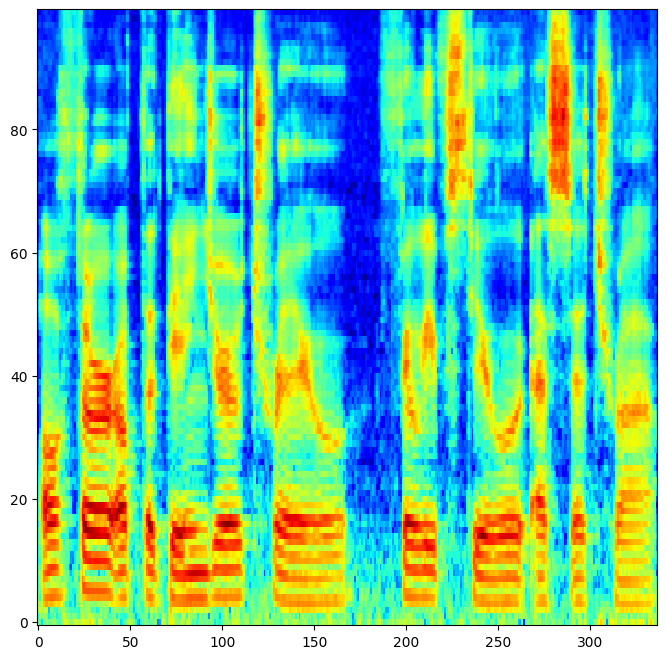

In [14]:
path = filenames[0]

print("Original")
y, sr = torchaudio.load(path)
play_audio(y, sr)

if fs!=sr:
    print("Downsampled")
    if y.size(0) > 1:  # mix to mono
        y = y.mean(dim=0, keepdim=True)
    y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=fs)
    play_audio(y, fs)

print("Vocoded")
mel = melgen(y[0])
audio = model.decode(mel.unsqueeze(0))
play_audio(audio, fs)
plot_spectrogram(cuda2numpy(mel))